In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def calc_dphi(phi1, phi2):
    dphi = phi2 - phi1
    dphi[dphi > np.pi] -= 2*np.pi
    dphi[dphi < -np.pi] += 2*np.pi
    return dphi

In [9]:
input_dir = './MPD_dataset/MPD_events'
rmaxlist = []
zminlist = []
zmaxlist = []
maxrowlist = []
minrowlist = []
particlenumlist = []
hitnumlist = []

phi_slope_list = []
distance_list = []
theta_list = []
z0_list = []

for evtid in range(10):
    event_name = input_dir + f'/event_{evtid}_'
    print(f'Processing: {event_name:s}')

    hits = pd.read_csv(event_name + 'hits.csv')
    r = np.sqrt(hits.x**2 + hits.y**2)
    phi = np.arctan2(hits.y, hits.x)
    hits = hits[['hit_id', 'z', 'row_id', 'sector_id']].assign(r=r, phi=phi)
    rmaxlist.append(hits['r'].max())
    zminlist.append(hits['z'].min())
    zmaxlist.append(hits['z'].max())
    minrowlist.append(hits['row_id'].min())
    maxrowlist.append(hits['row_id'].max())
    hitnumlist.append(len(hits))

    tracks = pd.read_csv(event_name + 'tracks.csv')
    particlenumlist.append(len(set(tracks['track_id'])))

    truth = pd.read_csv(event_name + 'truth.csv')

    truth = truth.merge(tracks[['track_id', 'pt']], on='track_id')
    hits = hits.merge(truth, on='hit_id')

    hits = hits[hits['pt'] >= 1]

    hit_gropus = hits.groupby("track_id")

    for x in set(hits['track_id']):
        track_df = hit_gropus.get_group(x).assign(evtid=1)
        hit_pairs = track_df.reset_index().merge(track_df.reset_index(), on='evtid', suffixes=('_1', '_2'))
        hit_pairs = hit_pairs[(hit_pairs['row_id_1'] == hit_pairs['row_id_2'] - 1) & (hit_pairs['sector_id_1'] == hit_pairs['sector_id_2'])]

        dphi = calc_dphi(hit_pairs.phi_1, hit_pairs.phi_2)
        dz = hit_pairs.z_2 - hit_pairs.z_1
        dr = hit_pairs.r_2 - hit_pairs.r_1
        phi_slope = dphi / dr
        z0 = hit_pairs.z_1 - hit_pairs.r_1 * dz / dr
        distance = np.sqrt(hit_pairs.r_1**2 + hit_pairs.r_2**2 - 2 * hit_pairs.r_1 * hit_pairs.r_2 * np.cos(dphi) + dz**2)
        theta = np.arctan(dz / dr)

        phi_slope_list.append(phi_slope.abs().max())
        distance_list.append(distance.abs().max())
        theta_list.append(theta.abs().max())
        z0_list.append(z0.abs().max())

Processing: ./MPD_dataset/MPD_events/event_0_
Processing: ./MPD_dataset/MPD_events/event_1_
Processing: ./MPD_dataset/MPD_events/event_2_
Processing: ./MPD_dataset/MPD_events/event_3_
Processing: ./MPD_dataset/MPD_events/event_4_
Processing: ./MPD_dataset/MPD_events/event_5_
Processing: ./MPD_dataset/MPD_events/event_6_
Processing: ./MPD_dataset/MPD_events/event_7_
Processing: ./MPD_dataset/MPD_events/event_8_
Processing: ./MPD_dataset/MPD_events/event_9_


In [10]:
np.array(phi_slope_list)[~np.isnan(np.array(phi_slope_list))].max()

np.float64(0.07123251461975008)

In [11]:
np.array(theta_list)[~np.isnan(np.array(theta_list))].max()

np.float64(1.4720831412686424)

In [12]:
np.array(z0_list)[~np.isnan(np.array(z0_list))].max()

np.float64(318.37014375408)

In [7]:
np.array(distance_list)[~np.isnan(np.array(distance_list))].max()

np.float64(11.953161700989428)

In [13]:
np.array(rmaxlist).max()

np.float64(123.13846256511407)

In [4]:
np.array(zminlist).min()

np.float64(-165.853)

In [5]:
np.array(zmaxlist).max()

np.float64(168.646)

In [6]:
np.array(minrowlist).min()

np.int64(0)

In [7]:
np.array(maxrowlist).max()

np.int64(52)

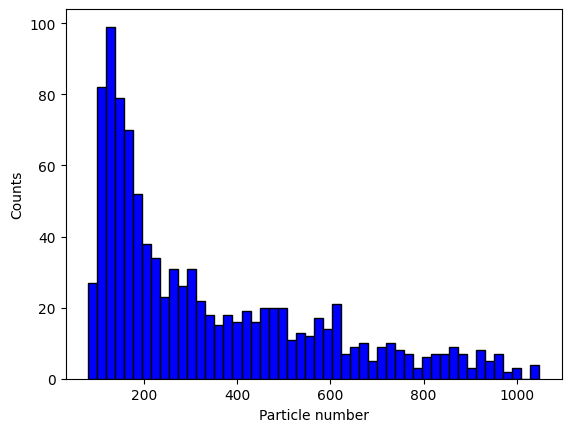

In [8]:
plt.hist(particlenumlist, bins=50, color='blue', edgecolor='black')

plt.ylabel('Counts')
plt.xlabel('Particle number')

plt.show()

In [9]:
print(f'{len([x for x in particlenumlist if x > 400]) / len(particlenumlist) * 100:.2f}%')

32.60%


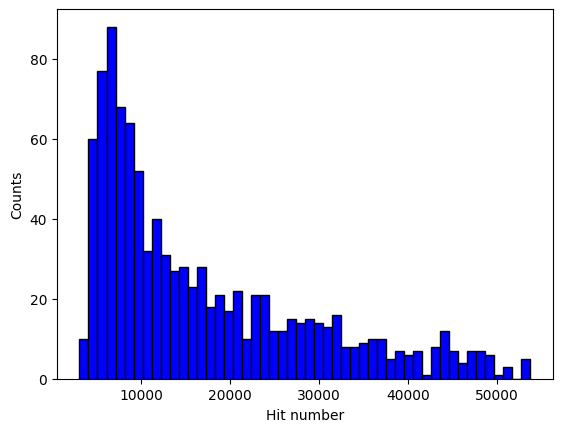

In [10]:
plt.hist(hitnumlist, bins=50, color='blue', edgecolor='black')

plt.ylabel('Counts')
plt.xlabel('Hit number')

plt.show()